# Credit Risk Resampling Techniques

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [22]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [23]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [31]:
df.dtypes

loan_amnt                     float64
int_rate                      float64
installment                   float64
home_ownership                 object
annual_inc                    float64
                               ...   
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
debt_settlement_flag           object
Length: 86, dtype: object

In [32]:
# Create our features
X = df.drop('loan_status', axis=1)
X=pd.get_dummies(X)

# Create our target
y = df['loan_status']

In [34]:
X.dtypes

loan_amnt                      float64
int_rate                       float64
installment                    float64
annual_inc                     float64
dti                            float64
                                ...   
next_pymnt_d_May-2019            uint8
application_type_Individual      uint8
application_type_Joint App       uint8
hardship_flag_N                  uint8
debt_settlement_flag_N           uint8
Length: 95, dtype: object

In [35]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [36]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [37]:
from sklearn.model_selection import train_test_split
# YOUR CODE HERE  by me 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)

Counter({'low_risk': 51366, 'high_risk': 246})

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [84]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [85]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

classifier.fit(X_resampled, y_resampled)

LogisticRegression()

In [86]:
# Display the confusion matrix    by me 
from sklearn.metrics import confusion_matrix, classification_report
y_pred=classifier.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   75    26]
 [ 6740 10364]]


In [87]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.6742571941946299

In [88]:
# Print the imbalanced classification report  
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.01      0.74      0.02       101
    low_risk       1.00      0.61      0.75     17104

    accuracy                           0.61     17205
   macro avg       0.50      0.67      0.39     17205
weighted avg       0.99      0.61      0.75     17205



### SMOTE Oversampling

In [89]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
ros = SMOTE(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [90]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression()

classifier1.fit(X_resampled, y_resampled)


LogisticRegression()

In [92]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.6623356588465208

In [91]:
# Display the confusion matrix
y_pred=classifier1.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   64    37]
 [ 5285 11819]]


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:

sns.set(font_scale=1.5)
# create a function for creating confusion matrix
def plot_conf_mat(y_test,y_preds):
    """
    Plots a nicer looking ocnfusion matrix using Seaborn's heatmap
    """
    fig,ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test,y_preds),
                     # display numbers on individual heatmap boxes (annotate)
                    annot=True, cbar=False,
                    cmap="YlGnBu")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

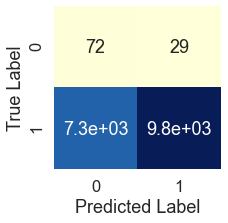

In [112]:
plot_conf_mat(y_test, y_pred)

In [96]:
# Print the imbalanced classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.01      0.63      0.02       101
    low_risk       1.00      0.69      0.82     17104

    accuracy                           0.69     17205
   macro avg       0.50      0.66      0.42     17205
weighted avg       0.99      0.69      0.81     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [97]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
ros = ClusterCentroids(random_state=1)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 246, 'low_risk': 246})

In [99]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
classifier2 = LogisticRegression()

classifier2.fit(X_resampled, y_resampled)



LogisticRegression()

In [102]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.5447339051023905

In [101]:
# Display the confusion matrix
y_pred=classifier2.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   70    31]
 [10324  6780]]


In [103]:
# Print the imbalanced classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.01      0.69      0.01       101
    low_risk       1.00      0.40      0.57     17104

    accuracy                           0.40     17205
   macro avg       0.50      0.54      0.29     17205
weighted avg       0.99      0.40      0.56     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [104]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN
ros =SMOTEENN(random_state=1)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 51361, 'low_risk': 46653})

In [105]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
classifier3 = LogisticRegression()

classifier3.fit(X_resampled, y_resampled)



LogisticRegression()

In [107]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.6433860645185192

In [106]:
# Display the confusion matrix
y_pred=classifier3.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[  72   29]
 [7288 9816]]


In [108]:
# Print the imbalanced classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.01      0.71      0.02       101
    low_risk       1.00      0.57      0.73     17104

    accuracy                           0.57     17205
   macro avg       0.50      0.64      0.37     17205
weighted avg       0.99      0.57      0.72     17205

